# Tarea 2
## Laboratorio de Datos

In [2]:
# librerías usadas
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 1 Carga y transformación de Datos

In [3]:
# 1
# iniciar datos
def load(path):
    image_rgb =Image.open(path).convert("RGB")
    return image_rgb

div= np.iinfo('uint8').max # maximo valor de tipo uint8
transformers=transforms.Compose(
                [transforms.Resize([224,224]),
                 transforms.RandomRotation(degrees=20),
                 transforms.RandomHorizontalFlip(),
                 transforms.ColorJitter(brightness=[1.2, 1.5]),
                 transforms.ToTensor()
                ])

# Usamos el loader por defecto de ImageFolder
# Deja las imagenes con 3 capas
from torchvision.datasets.folder import default_loader
    
data_train1=datasets.DatasetFolder(root='chest_xray/train',loader=default_loader,transform=transformers, extensions='jpeg')
data_test1=datasets.DatasetFolder(root='chest_xray/test',loader=default_loader,transform=transformers, extensions='jpeg')

bs=256
data_train=DataLoader(data_train1, batch_size=bs,shuffle=True)
data_test=DataLoader(data_test1, batch_size= bs* 2)


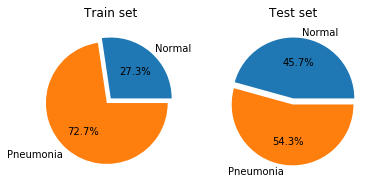

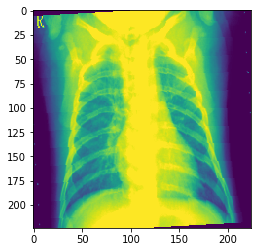

In [57]:
# 2
#tensors_train,classes_train = next(iter(data_train))
#tensors_test,classes_test = next(iter(data_test))

pneumonia_train=int(sum(classes_train))
normal_train=np.shape(tensors_train)[0]-pneumonia_train


pneumonia_test=int(sum(classes_test))
normal_test=np.shape(tensors_test)[0]-pneumonia_test

labels = 'Normal', 'Pneumonia'
sizes_train = [normal_train/np.shape(tensors_train)[0], pneumonia_train/np.shape(tensors_train)[0]]

sizes_test = [normal_test, pneumonia_test]

fig, axs = plt.subplots(1,2)
axs[0].pie(sizes_train,labels=labels,explode=(0,0.1),autopct='%1.1f%%')
axs[1].pie(sizes_test,labels=labels,explode =(0,0.1),autopct='%1.1f%%')

axs[0].set_title('Train set')
axs[1].set_title('Test set')

plt.show()

# plotear una imagen
plt.imshow(tensors_train[0][0])
plt.show()

In [100]:
# 3

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# split
train_idx, val_idx = train_test_split(list(range(len(data_train1))),test_size=0.2)
data_train = Subset(data_train1, train_idx)
data_val   = Subset(data_train1,val_idx)
# load
data_train = DataLoader(data_train, batch_size=bs,shuffle=True)
data_bal   = DataLoader(data_val, batch_size=bs,shuffle=True)




class ReplicarMuestreoDePrueba(torch.utils.data.Sampler):
    def __init__(self,etiquetas_prueba, indices_val, etiquetas_val):
        pass
    def __iter__(self):
        pass
    
    

In [4]:
inputs,classes = next(iter(data_train))

In [ ]:
"""
To Do : 

Perfilamiento de tiempo de cómputo 

Comparación de las librerias pytorch PIL skimage opencv

"""